<a href="https://colab.research.google.com/github/CosiFun515/TextMining_Liu/blob/main/732A81_Project_code_Ziomek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install sentence_transformers
!pip install tweet-preprocessor
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.8 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=adf797b234906621d51eec6d5b3b7be0cb0b3592397e887e5821666206e70672
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence_transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.o

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
from google.colab import drive

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import os
from sentence_transformers import SentenceTransformer

import re
import preprocessor as p
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
nltk.download('omw-1.4') # required for wordnet
nltk.download('punkt')
nltk.download("stopwords")
nltk.download("wordnet")

import plotly.express as px
import plotly.graph_objects as go

import openai

from openai.embeddings_utils import get_embedding

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 1. Read in data


In [6]:
#jobs = pd.read_excel("/content/drive/MyDrive/datasets/manually_retrieved_jobs.xlsx", 
#                     index_col=[0])
jobs = pd.read_csv('/content/drive/My Drive/datasets/jobs_w_text_embeddings.csv',
                   index_col=[0])
jobs.reset_index(inplace=True)
jobs.rename(columns = {"index":"id"}, inplace=True) # creating id
jobs.fillna(" ", inplace=True)
jobs["all_text"] = jobs.description + ". " + jobs.requirements
jobs.job_generic.value_counts()

Data Engineer       117
Business Analyst    104
Data Analyst        100
ML Engineer          83
DevOps Engineer      82
Data Scientist       82
Cloud Engineer       55
Name: job_generic, dtype: int64

## Defining functions for analysis


In [7]:
def calculate_all_kmeans(cluster_range, corpus_embeddings):
  '''
    calculate all kmeans clustering for given cluster_range and
    given embedding
    # 1. run kmeans for k cluster
    # 2. get cluster assignment for text
    # 3. get inertia for k cluster
    # 4. get silhouette score for k cluster
  '''
  scores = [0]
  for n_cluster in cluster_range:

    print(f"##### running kmeans for {n_cluster=} cluster")

    # initialize + run model
    modelkmeans = KMeans(n_clusters=n_cluster, 
                        init="k-means++", 
                        n_init=20, 
                        random_state=324)
    modelkmeans.fit(corpus_embeddings)
    #jobs_df["kmeans_" + str(n_cluster)] = modelkmeans.labels_ 

    if n_cluster > 1:
      # getting scores
      scores.append(
          metrics.silhouette_score(corpus_embeddings, modelkmeans.labels_)
      )
    
  # avg. silhouette width DF
  scores_df = pd.DataFrame([range(1,8), scores]).transpose()
  scores_df.columns = ["n_cluster", "scores"]

  return scores_df

In [8]:
## Silhouette plot
def create_silhouette_plot(scores_df, modelname, best_n_cluster):
  fig1 = px.line(scores_df, x="n_cluster", y="scores")
  fig1.update_traces(line=dict(color = 'rgba(50,50,50,0.2)'))

  fig2 = px.scatter(scores_df, x="n_cluster", y="scores")

  layout = go.Layout(
      title=f"Optimal number of clusters for K-Means for {modelname}, Silhouette plot",
      title_x=0.5,
      xaxis=dict(
          title="number of clusters k"
      ),
      yaxis=dict(
          title="avg. silhouette width"
      ) ) 

  fig3 = go.Figure(layout = layout, data=fig1.data + fig2.data)
  fig3.add_vline(x=best_n_cluster, 
                line_width=1, 
                line_dash="dot",
                line_color="gray")
  fig3.show()

In [9]:
# plotting word cloud of 25 most relevant tokens per cluster
def wordcloud(cluster_df, cluster, corpus):
  wc = " ".join([text for text in cluster_df.loc[cluster_df.cluster==cluster, corpus]])
  wordcloud = WordCloud(width=800, 
                        height=500,
                        random_state=21, 
                        max_font_size=80,
                        background_color="white",
                        max_words=25,
                        ).generate(wc)
  fig7 = plt.figure(figsize=(10,7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")


## 3. Tf-idf: Clustering without context 


### 3.1 pre-processing 


In [10]:
################# CLUSTERING WITHOUT CONTEXT ##############
# Cleaning the text NOT FOR BERT, ONLY FOR WITHOUT CONTEXT
def text_preprocess(text):

    add_stopwords = ["skill", "ability", "experience", "the", "any",
                     "requirement", "you"]
    stemmer = WordNetLemmatizer()
    tokens = [w for w in word_tokenize(text) if w.isalpha()] # remove digits as well
    nopunc = [char for char in tokens if char not in string.punctuation]
    no_stops = [word.lower() for word in nopunc if 
              word not in stopwords.words("english")]
    lemmas = [stemmer.lemmatize(word) for word in no_stops]
    final = [word for word in lemmas if word not in add_stopwords]

    return final


In [11]:
# preprocess data + join back to one string per document/job description
jobs["all_text_clean"] = jobs.all_text.apply(text_preprocess)
jobs["all_text_clean_str"] =  jobs.all_text_clean.apply(lambda x: ' '.join(x))

### 3.2 numerical representation by tf-idf Vectorizer


In [12]:
# numerical transformation tf-idf
tfidfconvert = TfidfVectorizer(ngram_range=(1,2), min_df = 5, max_df = 0.7)
tfidfconvert.fit(jobs.all_text_clean_str)
jobs_transformed = tfidfconvert.transform(jobs.all_text_clean_str)

### 3.3 running K-means for n_cluster range

In [13]:
scores_df_tfidf = calculate_all_kmeans(cluster_range = range(1,8), 
                                      corpus_embeddings = jobs_transformed)

##### running kmeans for n_cluster=1 cluster
##### running kmeans for n_cluster=2 cluster
##### running kmeans for n_cluster=3 cluster
##### running kmeans for n_cluster=4 cluster
##### running kmeans for n_cluster=5 cluster
##### running kmeans for n_cluster=6 cluster
##### running kmeans for n_cluster=7 cluster


In [ ]:
scores_df_tfidf

,n_cluster,scores
0,1.0,0.000000
1,2.0,0.016265
2,3.0,0.020491
3,4.0,0.019525
4,5.0,0.018657
5,6.0,0.015616
6,7.0,0.010970


### 3.4 silhouette plot for tf-idf

In [14]:
# create silhouette plot for tfidf
best_n_cluster_tfidf = int(scores_df_tfidf.loc[scores_df_tfidf.scores==scores_df_tfidf.scores.max(), 
                                    "n_cluster"].iloc[0])
create_silhouette_plot(scores_df = scores_df_tfidf,
                modelname = "tf-idf",
                best_n_cluster = best_n_cluster_tfidf)

### 3.5 running best k-means tf-idf

In [15]:
# tfidf: get final model + word clouds
# create K-means with best n_cluster
modelkmeans = KMeans(n_clusters=best_n_cluster_tfidf, 
                       init="k-means++", 
                       n_init=20, 
                       random_state=324)
modelkmeans.fit(jobs_transformed)
jobs["kmeans_tfidf_final"] =  modelkmeans.labels_ 

### 3.6 most important tokens per cluster

In [16]:
### Getting most important tokens of clusters
order_centroids = modelkmeans.cluster_centers_.argsort()[:, ::-1]
feature_names = tfidfconvert.get_feature_names_out()
Clusters = pd.DataFrame()
for i in range(best_n_cluster_tfidf):
  Clusters.at[int(i), "cluster"] = int(i)
  Clusters.at[i, "corpus"] = (",".join([feature_names[x] for x in order_centroids[i, :25]]))

Clusters["cluster"] = Clusters.cluster.astype(int)

In [ ]:
Clusters

,cluster,corpus
0,0,"business,analysis,process,project,client,work,..."
1,1,"cloud,infrastructure,system,pipeline,aws,techn..."
2,2,"learning,machine,machine learning,model,ml,alg..."


### 3.7 word clouds per cluster

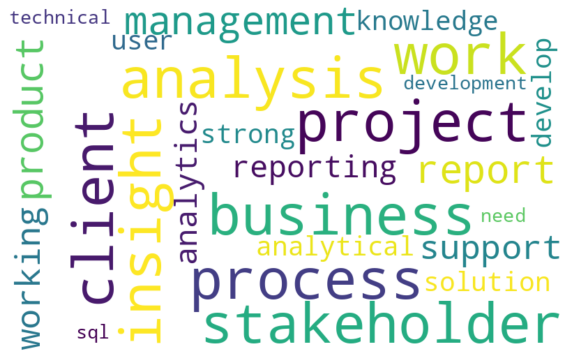

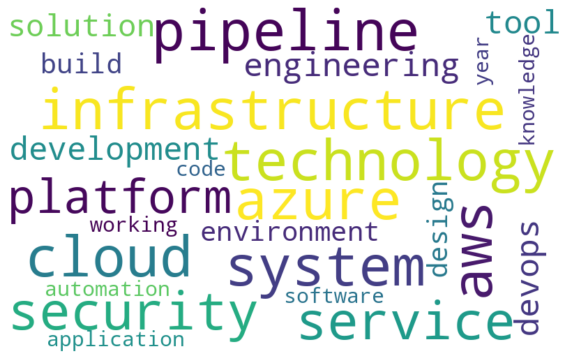

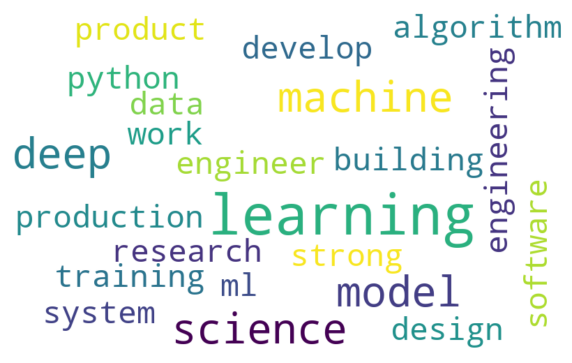

In [18]:
# wordcloud for clusters
for cluster in range(best_n_cluster_tfidf):

  wordcloud(cluster_df=Clusters,
            cluster=cluster,
            corpus="corpus")

## 4. SBERT: Clustering with context

### 4.1 pre-processing

In [19]:
################### Clustering with SBERT #########
def clean_description(text):
  replace_no_space_punc = re.compile("(\.)|(\,)|(\:)|(\()|(\))")
  replace_no_space = re.compile(r'[0-9]+')
  tmpL = p.clean(text)
  tmpL2 = replace_no_space.sub("", tmpL) 
  tmpL3 = replace_no_space_punc.sub("", tmpL2)
  tmpL4 = tmpL3.lower() 

  return tmpL4


jobs["all_text_clean_BERT"] = jobs.description.apply(clean_description)

In [20]:
# check lenght of pre-processed text
def get_text_length(text):
    
    return len(text.split())

jobs["text_length"] = jobs.all_text_clean_BERT.apply(get_text_length)
jobs.text_length.describe()
jobs_subset = jobs[jobs.text_length>1].copy()

### 4.2 numerical representation by sentence embedding

In [21]:
# sentence embedding SBERT
embedder = SentenceTransformer('bert-base-nli-mean-tokens')
corpus = list(jobs_subset["all_text_clean_BERT"])
corpus_embeddings = embedder.encode(corpus)

### 4.3 running K-means for n_cluster range

In [22]:
#### kmeans with SBERT
scores_df_BERT = calculate_all_kmeans(cluster_range = range(1,8), 
                                      corpus_embeddings = corpus_embeddings)
scores_df_BERT

##### running kmeans for n_cluster=1 cluster
##### running kmeans for n_cluster=2 cluster
##### running kmeans for n_cluster=3 cluster
##### running kmeans for n_cluster=4 cluster
##### running kmeans for n_cluster=5 cluster
##### running kmeans for n_cluster=6 cluster
##### running kmeans for n_cluster=7 cluster


,n_cluster,scores
0,1.0,0.000000
1,2.0,0.065918
2,3.0,0.067603
3,4.0,0.072410
4,5.0,0.070356
5,6.0,0.069235
6,7.0,0.058223


### 4.4 silhouette plot for SBERT

In [23]:
best_n_cluster_BERT = int(scores_df_BERT.loc[scores_df_BERT.scores==scores_df_BERT.scores.max(), 
                                    "n_cluster"].iloc[0])
create_silhouette_plot(scores_df = scores_df_BERT,
                modelname = "SBERT",
                best_n_cluster = best_n_cluster_BERT)

### 4.5 running best k-means SBERT

In [24]:
#### final kmeans BERT
clustering_model = KMeans(n_clusters=best_n_cluster_BERT, 
                       init="k-means++", 
                       n_init=20, 
                       random_state=324)
clustering_model.fit(corpus_embeddings) # fitting embedding
jobs_subset["kmeans_BERT_final"] = clustering_model.labels_


### 4.6 word clouds per cluster

In [25]:
cluster_df_BERT = pd.DataFrame(corpus, columns = ["corpus"]) # raw corpus, no embeddings
cluster_df_BERT["cluster"] = clustering_model.labels_
cluster_df_BERT.head()

,corpus,cluster
0,you will work closely with sales account manag...,1
1,reporting to the head of commercial finance yo...,1
2,ensuring that ryde is continually learning fro...,0
3,our analytics team helps clients make decision...,1
4,you will take responsibility for managing our ...,3


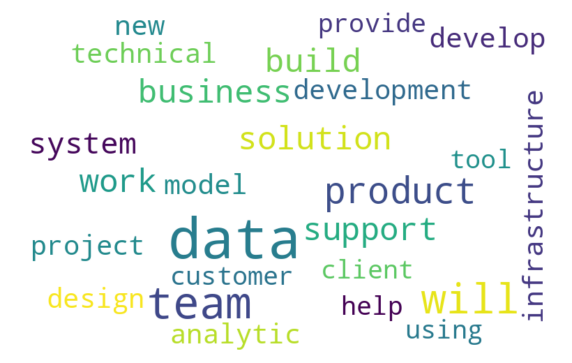

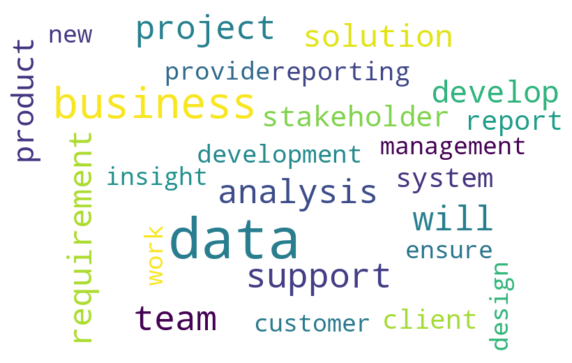

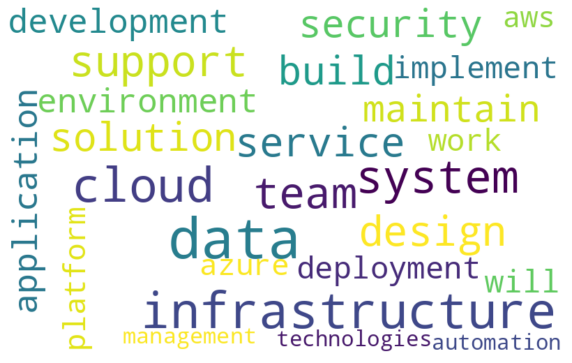

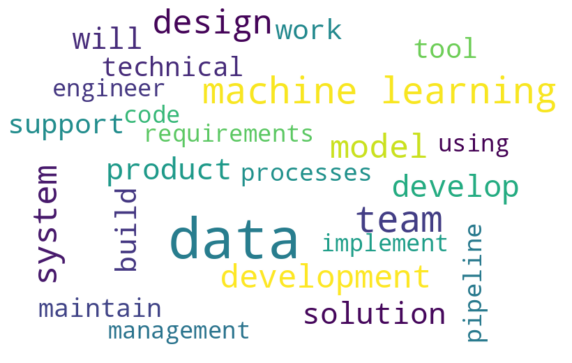

In [ ]:
for cluster in range(best_n_cluster_BERT):

  wordcloud(cluster_df=cluster_df_BERT,
            cluster=cluster,
            corpus="corpus")

## 5. Text embedding: Clustering with context

### 5.1 pre-processing

In [26]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191
#openai.api_key = <my_key>

In [27]:
# preprocessing
def clean_description_openai(text):
  replace_no_space = re.compile(r'[0-9]+')
  tmpL = replace_no_space.sub("", text)
  return tmpL

jobs["all_text_clean_openai"] = jobs.all_text.apply(clean_description_openai)

In [ ]:
jobs["all_text_clean_openai"]

0      you will work closely with sales, account mana...
1      Reporting to the Head of Commercial Finance yo...
2      Ensuring that Ryde is continually learning fro...
3      Our Analytics team helps clients make decision...
4      You will take responsibility for managing our ...
                             ...                        
618    will design, build, and maintain bioinformatic...
619    Perform day-to-day quantitative risk analysis ...
620    Collects, compiles, and presents metrics and d...
621    Leads teams creating repeatable, interpretable...
622    to discover deeper insights, make predictions,...
Name: all_text_clean_openai, Length: 623, dtype: object

### 5.2 numerical representation by text embeddings

In [ ]:
# this is only run for training, for this, an openai.api_key is required! 
# for re-running, read in dataset with embeddings (see beginning of notebook)

# jobs["text_embedding"] = jobs.all_text_clean_openai.apply(lambda x: get_embedding(x, engine=embedding_model))
# path = '/content/drive/My Drive/datasets/jobs_w_text_embeddings.csv'
# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   jobs.to_csv(f)

In [28]:
jobs["text_embedding_float"] = jobs.text_embedding.apply(eval).apply(np.array)
matrix = np.vstack(jobs.text_embedding_float.values)
matrix.shape

(623, 1536)

### 5.3 running K-means for n_cluster range

In [29]:
scores_df_openai = calculate_all_kmeans(cluster_range = range(1,8), 
                                      corpus_embeddings = matrix)

##### running kmeans for n_cluster=1 cluster
##### running kmeans for n_cluster=2 cluster
##### running kmeans for n_cluster=3 cluster
##### running kmeans for n_cluster=4 cluster
##### running kmeans for n_cluster=5 cluster
##### running kmeans for n_cluster=6 cluster
##### running kmeans for n_cluster=7 cluster


In [30]:
scores_df_openai

,n_cluster,scores
0,1.0,0.000000
1,2.0,0.071200
2,3.0,0.076923
3,4.0,0.064194
4,5.0,0.070652
5,6.0,0.056951
6,7.0,0.048191


### 5.4 silhouette plot for text embedding

In [31]:
best_n_cluster_openai = int(scores_df_openai.loc[scores_df_openai.scores==scores_df_openai.scores.max(), 
                                    "n_cluster"].iloc[0])
create_silhouette_plot(scores_df = scores_df_openai,
                modelname = "text_embedding",
                best_n_cluster = best_n_cluster_openai)

### 5.5 running best k-means text embedding

In [32]:
#### final kmeans openai
clustering_model = KMeans(n_clusters=best_n_cluster_openai,
                          init="k-means++", 
                          n_init=20, 
                          random_state=324)
clustering_model.fit(matrix) # fitting embedding
jobs["kmeans_openai_final"] = clustering_model.labels_


### 5.6 word clouds per cluster

In [ ]:
cluster_df_openai = pd.DataFrame(list(jobs["all_text_clean_openai"]), columns = ["corpus"]) # raw corpus, no embeddings
cluster_df_openai["cluster"] = clustering_model.labels_
cluster_df_openai.head()

,corpus,cluster
0,"you will work closely with sales, account mana...",0
1,Reporting to the Head of Commercial Finance yo...,0
2,Ensuring that Ryde is continually learning fro...,0
3,Our Analytics team helps clients make decision...,0
4,You will take responsibility for managing our ...,0


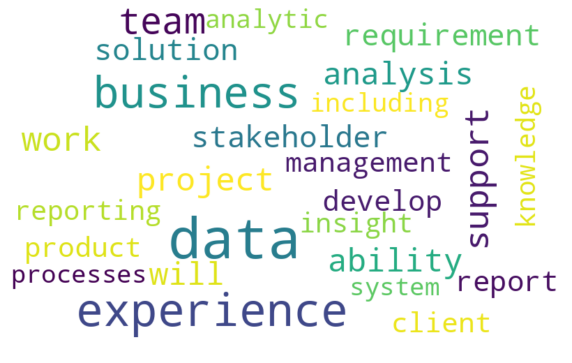

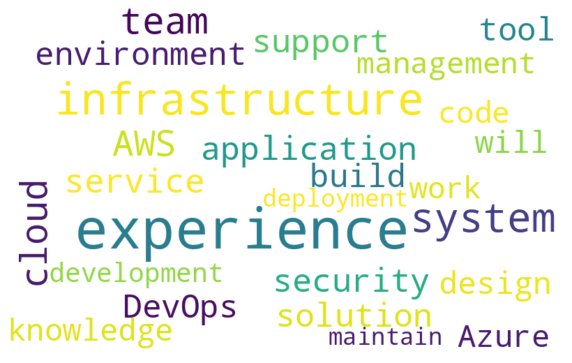

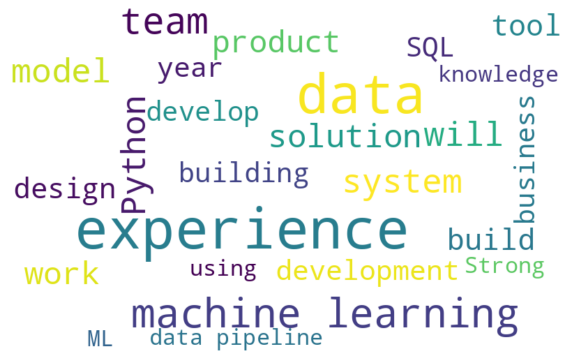

In [ ]:
for cluster in range(best_n_cluster_openai):

  wordcloud(cluster_df=cluster_df_openai,
            cluster=cluster,
            corpus="corpus")

## 6. overall statistics

### 6.1 cluster distribution over all methods

In [33]:
# get cluster distribution over all methods
jobs_all = jobs.merge(jobs_subset[["id", "kmeans_BERT_final"]], on="id")

In [34]:
jobs_all.columns

Index(['id', 'retrieved_date', 'company', 'job', 'job_generic', 'description',
       'requirements', 'text_embedding', 'all_text', 'all_text_clean',
       'all_text_clean_str', 'kmeans_tfidf_final', 'all_text_clean_BERT',
       'text_length', 'all_text_clean_openai', 'text_embedding_float',
       'kmeans_openai_final', 'kmeans_BERT_final'],
      dtype='object')

In [42]:
jobs_all[["job_generic","kmeans_tfidf_final", "kmeans_BERT_final","kmeans_openai_final"]]
pd.crosstab(jobs_all.job_generic, jobs_all.kmeans_tfidf_final)
pd.crosstab(jobs_all.job_generic, jobs_all.kmeans_BERT_final)
pd.crosstab(jobs_all.job_generic, jobs_all.kmeans_openai_final)
pd.crosstab(jobs_all.kmeans_BERT_final, jobs_all.kmeans_tfidf_final)
pd.crosstab(jobs_all.kmeans_BERT_final, jobs_all.kmeans_openai_final)
pd.crosstab(jobs_all.kmeans_tfidf_final, jobs_all.kmeans_openai_final)
pd.crosstab(jobs_all.job_generic, jobs_all.kmeans_BERT_final)

kmeans_BERT_final,0,1,2,3
job_generic,,,,
Business Analyst,6,91,2,5
Cloud Engineer,7,1,43,3
Data Analyst,33,58,0,9
Data Engineer,61,14,18,23
Data Scientist,18,29,0,35
DevOps Engineer,30,1,33,16
ML Engineer,27,5,6,45


### 6.2 silhouette plot over all methods

In [ ]:
# get silhouette plot for all methods
all_scores_df = pd.concat([scores_df_tfidf, scores_df_BERT, scores_df_openai])
classes_uniq = ["tf-idf", "SBERT", "openai"]
classes = np.repeat(classes_uniq,7)
all_scores_df["classes"] = classes

In [ ]:
##### silhouette plot for all results
#best_n_cluster = int(scores_df.loc[scores_df.scores==scores_df.scores.max(), 
#                                    "n_cluster"].iloc[0])

fig1 = px.line(all_scores_df, x="n_cluster", y="scores", color="classes")

fig2 = px.scatter(all_scores_df, x="n_cluster", y="scores", color="classes")

layout = go.Layout(
    title=f"Optimal number of clusters for K-Means, Silhouette plot",
    title_x=0.5,
    xaxis=dict(
        title="number of clusters k"
    ),
    yaxis=dict(
        title="avg. silhouette width"
    ) ) 

figX = go.Figure(layout = layout, data=fig1.data + fig2.data)
figX.update_layout(showlegend=True)
figX.show()

In [ ]:
all_scores_df.columns = ["n_cluster", "scores_tfidf", "scores_BERT", "scores_openai"]
all_scores_df

,n_cluster,tfidf_scores,BERT_scores,openai_scores
0,1.0,0.000000,0.000000,0.000000
1,2.0,0.016265,0.065918,0.071200
2,3.0,0.020491,0.067603,0.076923
3,4.0,0.019525,0.072410,0.064194
4,5.0,0.018657,0.070356,0.070652
5,6.0,0.015616,0.069235,0.056951
6,7.0,0.010970,0.058223,0.048191
